## Gridworld LLM Planner Experiments

In this notebook, we evaluate the results of the Gridworld experiments performed in a planner-actor-reporter setup. We run the experiment across $5$ random seeds. To generate the results, please refer to the README.md file.

In [ ]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from dotenv import load_dotenv

from ced.actors.grid import GridWorldActor
from ced.tools.utils import find_by_id, to_device

In [2]:
_ = sns.set_theme(
    style="white", context="paper",
    rc={
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "font.size": 25,
        "axes.titlesize": 25,
        "axes.labelsize": 25,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "legend.fontsize": 20,
        "legend.title_fontsize": 20,
        "figure.figsize": (6.4, 6.4),
    },
)

In [3]:
plt_skip_legend = False
plt_palette = {
    "SSE": "#713580", "r-SSE": "#a15ab3", "TCFE": "#00cb77",
    "total-ASE": "#0074a3", "A1-ASE": "black", "A2-ASE": "#0098d7", "Planner-ASE": "black",
    "[0-10]": "black", "11": "#b51d65", "12": "#dd2d5a", "13": "#eb5e5f", "14": "#fa9072", "[15-20]": "black", 
}

plt_effects_title = ""
plt_effects_x_label = "Effect Value"
plt_effects_y_label = ""

plt_contributions_title = ""
plt_contributions_x_label = "Time-Step"
plt_contributions_y_label = "Contribution Ratio"

## Helper Functions

In this section we define some helper functions used throughout the notebook.

In [4]:
def load_actor(path: str, id: int, device: str) -> GridWorldActor:
    policy = torch.load(path, map_location=device)["policy"].eval()
    policy = to_device(policy, device)
    actor = GridWorldActor(id, policy)
    return actor

## Experiments

In the following sections, we perform analysis for different experimental phases. Make sure to update the location of the `.env` file, should it differ from the default (see also `llm_setup.ipynb`).

In [5]:
env_path = Path("./.env")
results_dir = Path("./results/grid")
plots_dir = Path("./plots/grid")
seeds = [5656992596, 7989549204, 4429586919, 9986573471, 4459386742]

In [6]:
_ = load_dotenv(dotenv_path=env_path)

In [7]:
device = "cpu"
a1 = load_actor(results_dir / "a1_policy.pt", id=0, device=device)
a2_phase4 = load_actor(results_dir / "a2_policy.pt", id=1, device=device)

In [ ]:
with open(results_dir / "trajectories.pkl", "rb") as f:
    trajectories = pickle.load(f)
    p4_tcfe = pd.read_csv(results_dir / "p4_trajectories.csv")
    p3_tcfe = pd.read_csv(results_dir / "p3_trajectories.csv")

### Trajectory Analysis

We commence by analysing sampled trajectories and the total counterfactual effect (TCFE) of intervening on A2's pickup action with an alternative `pickup green` action. Because A2 follows the pink corridor, we expect to see a positive TCFE for cases when it received $4$ highest penalties.

In [9]:
order = list(reversed([str([-25., -25., -25., -25.]), str([-15., -25., -25., -25.]), str([-25., -15., -25., -25.]), str([-25., -25., -15., -25.]), str([-25., -25., -25., -15.])]))
penalties = [str(t.get_corridor_penalties(agent_id=1, corridor="pink")) for t in trajectories]

In [10]:
p4_tcfe["penalties (A2, pink)"] = pd.Categorical(penalties, categories=order)
p4_tcfe = p4_tcfe.sort_values(by=["tcfe"], ascending=False)
p4_tcfe

,traj_id,seed,tcfe,"penalties (A2, pink)"
1,1,129352,23.516028,"[-25.0, -25.0, -25.0, -25.0]"
6,6,295131,18.610738,"[-25.0, -15.0, -25.0, -25.0]"
7,7,684305,18.516404,"[-25.0, -25.0, -15.0, -25.0]"
0,0,248503,18.430336,"[-25.0, -15.0, -25.0, -25.0]"
4,4,994998,17.946849,"[-25.0, -25.0, -15.0, -25.0]"
8,8,739705,17.536050,"[-25.0, -25.0, -25.0, -15.0]"
2,2,437188,16.744911,"[-25.0, -25.0, -25.0, -15.0]"
3,3,330690,15.322737,"[-15.0, -25.0, -25.0, -25.0]"
5,5,653085,15.229219,"[-15.0, -25.0, -25.0, -25.0]"
9,9,120545,14.972615,"[-15.0, -25.0, -25.0, -25.0]"


In [11]:
print(find_by_id(trajectories, p4_tcfe.iloc[0].traj_id).render())

GridWorld Trajectory 1: Box 1 ('PINK', 'YELLOW'); Box 2 ('PINK', 'GREEN');
    Step: 0; Reporter:  Position (A1, A2): [23, 47]; Inventory (A1, A2): NULL, NULL;
             Planner: ('examine box 1', 'examine box 2'); Reward 0.0;
    Step: 1; Actors (A1, A2): up, down; Position (A1, A2): [23, 47]; Reward: -0.4 (A1: -0.2, A2: -0.2)
    Step: 2; Reporter:  Position (A1, A2): [11, 59]; Inventory (A1, A2): NULL, NULL;
             Planner: ('pickup pink', 'pickup pink'); Reward 0.0;
    Step: 3; Actors (A1, A2): pickup_pink, pickup_pink; Position (A1, A2): [11, 59]; Reward: -0.4 (A1: -0.2, A2: -0.2)
    Step: 4; Reporter:  Position (A1, A2): [11, 59]; Inventory (A1, A2): PINK, PINK;
             Planner: ('goto pink', 'goto pink'); Reward 0.0;
    Step: 5; Actors (A1, A2): down, up; Position (A1, A2): [11, 59]; Reward: -0.4 (A1: -0.2, A2: -0.2)
    Step: 6; Actors (A1, A2): left, up; Position (A1, A2): [23, 47]; Reward: -0.4 (A1: -0.2, A2: -0.2)
    Step: 7; Actors (A1, A2): left, up; Posi

Next, we show the TCFE of intervening on the Planner's instruction, forcing it to direct A2 to pickup the green object. This experiment was a part of our additional results reported in the appendix.

In [12]:
p3_tcfe["penalties (A2, pink)"] = pd.Categorical(penalties, categories=order)
p3_tcfe = p3_tcfe.sort_values(by=["tcfe"], ascending=False)
p3_tcfe

,traj_id,seed,tcfe,"penalties (A2, pink)"
1,1,267009,23.739867,"[-25.0, -25.0, -25.0, -25.0]"
0,0,335540,19.095595,"[-25.0, -15.0, -25.0, -25.0]"
6,6,117993,18.696265,"[-25.0, -15.0, -25.0, -25.0]"
7,7,869979,18.119716,"[-25.0, -25.0, -15.0, -25.0]"
4,4,402694,17.948205,"[-25.0, -25.0, -15.0, -25.0]"
2,2,324868,17.449614,"[-25.0, -25.0, -25.0, -15.0]"
8,8,196013,17.313106,"[-25.0, -25.0, -25.0, -15.0]"
5,5,559277,15.315216,"[-15.0, -25.0, -25.0, -25.0]"
9,9,638350,14.961987,"[-15.0, -25.0, -25.0, -25.0]"
3,3,657700,14.388452,"[-15.0, -25.0, -25.0, -25.0]"


### Analysing counterfactual effects (intervening on A2's action): total-ASE, SSE, -r-SSE

In this section, we show our analysis for several counterfactual effects, focusing on the trajectory with the highest TCFE. To beging with, we show the results for intervening on the A2's action, forcing it to pickup the green object.

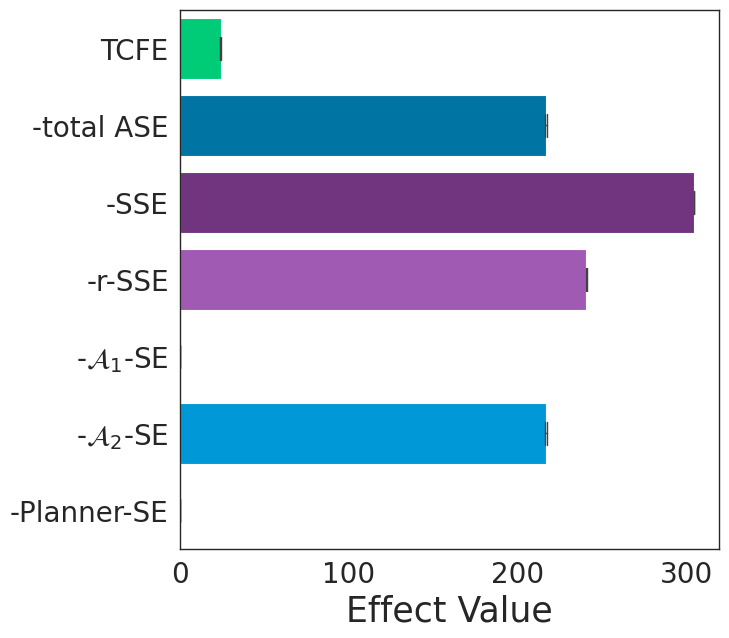

In [13]:
p4_quantities = pd.concat(pd.read_csv(results_dir / str(s) / "p4_causal_quantities.csv") for s in seeds)
p4_quantities

order = ["TCFE", "total-ASE", "SSE", "r-SSE", "A1-ASE", "A2-ASE", "Planner-ASE"]
df = p4_quantities.drop(columns=["reverse_sse_icc"])
df = df.rename(columns={"tcfe": "TCFE", "ase_total": "total-ASE", "ase_0": "A1-ASE", "ase_1": "A2-ASE", "ase_2": "Planner-ASE", "sse": "SSE", "reverse_sse": "r-SSE"})

for column in order[1:]:
    # plot the negative of the effects, for visual consistency
    df[column] = -1 * df[column]

df = pd.melt(df, id_vars=["seed", "traj_id"])
df["variable"] = pd.Categorical(df["variable"], categories=order, ordered=True)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax = sns.barplot(data=df, x="value", y="variable", palette=plt_palette, errorbar=("se", 2), errwidth=1, capsize=0.3, saturation=1.0, orient="h", ax=ax) 
ax.set_title(plt_effects_title)
ax.set_xlabel(plt_effects_x_label)
ax.set_ylabel(plt_effects_y_label)
ax.yaxis.set_ticklabels(["TCFE", "-total ASE", "-SSE", "-r-SSE", "-$\\mathcal{A}_1$-SE", "-$\\mathcal{A}_2$-SE", "-Planner-SE"])
ax.set_box_aspect(1)

if plt_skip_legend: _ = ax.get_legend().remove()
fig.savefig(plots_dir / "p4_tmain_quantities.pdf", bbox_inches="tight")

### Analysing counterfactual effects (intervening on Planner's action): total-ASE, SSE, -r-SSE

Next, we show our analysis for the case of intervening on the Planner's action, forcing it to instruct the A2 agent to pickup the green object.

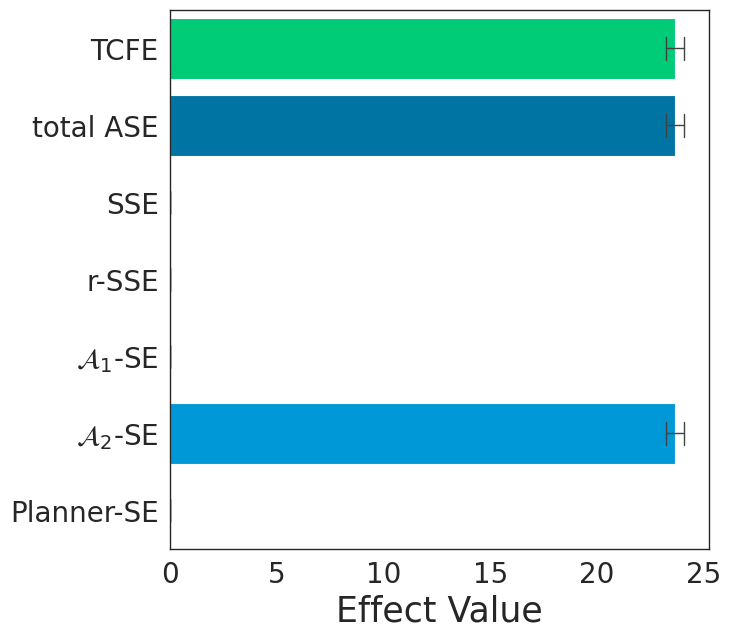

In [14]:
p3_quantities = pd.concat(pd.read_csv(results_dir / str(s) / "p3_causal_quantities.csv") for s in seeds)
p3_quantities

order = ["TCFE", "total-ASE", "SSE", "r-SSE", "A1-ASE", "A2-ASE", "Planner-ASE"]
df = p3_quantities.drop(columns=["reverse_sse_icc"])
df = df.rename(columns={"tcfe": "TCFE", "ase_total": "total-ASE", "ase_0": "A1-ASE", "ase_1": "A2-ASE", "ase_2": "Planner-ASE", "sse": "SSE", "reverse_sse": "r-SSE"})

df = pd.melt(df, id_vars=["seed", "traj_id"])
df["variable"] = pd.Categorical(df["variable"], categories=order, ordered=True)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax = sns.barplot(data=df, x="value", y="variable", palette=plt_palette, errorbar=("se", 2), errwidth=1, capsize=0.3, saturation=1.0, orient="h", ax=ax) 
ax.set_title(plt_effects_title)
ax.set_xlabel(plt_effects_x_label)
ax.set_ylabel(plt_effects_y_label)
ax.yaxis.set_ticklabels(["TCFE", "total ASE", "SSE", "r-SSE", "$\\mathcal{A}_1$-SE", "$\\mathcal{A}_2$-SE", "Planner-SE"])
ax.set_box_aspect(1)

if plt_skip_legend: _ = ax.get_legend().remove()
fig.savefig(plots_dir / "p3_tmain_quantities.pdf", bbox_inches="tight")

### Analysing intrinsic causal contribution results

In this section, we show the results for the reverse state-specific effect intrinsic causal contribution analysis.

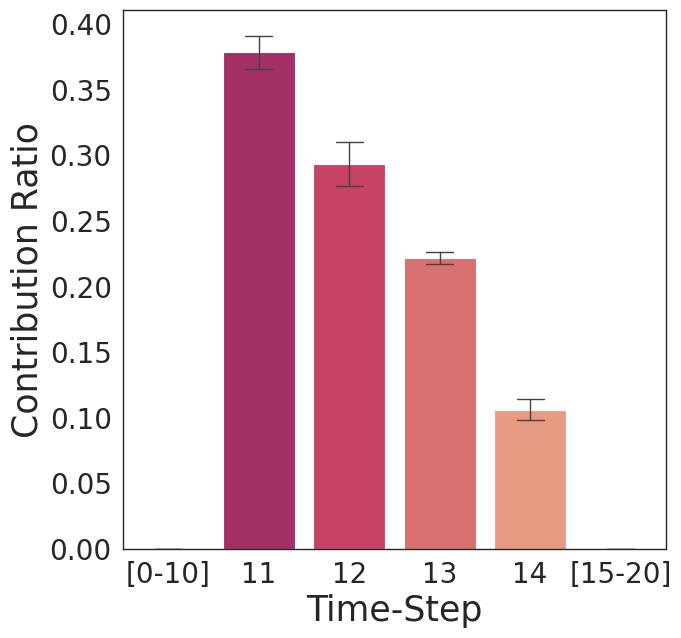

In [15]:
df = p4_quantities.copy()
contributions = []

for i in range(len(df)):
    sse_icc = df.iloc[i]["reverse_sse_icc"].strip("[]").split(", ")
    sse_icc = list(map(float, sse_icc))
    
    assert all([i == 0 for i in sse_icc[:11]]), "We expect steps [0-10] to have 0 contribution."
    assert all([i == 0 for i in sse_icc[15:]]), "We expect steps [15-20] to have 0 contribution."
    sse_icc = [0.0, *sse_icc[11:15], 0.0]
    
    sse_icc = np.array(sse_icc) / df.iloc[i]["reverse_sse"]
    contributions.append(sse_icc.tolist())

contributions_df = pd.DataFrame(contributions, columns=["[0-10]", "11", "12", "13", "14", "[15-20]"])

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax = sns.barplot(data=contributions_df, errorbar=("se", 2), errwidth=1, capsize=0.3, palette=plt_palette, ax=ax)
ax.set_xlabel(plt_contributions_x_label)
ax.set_ylabel(plt_contributions_y_label)
ax.set_title(plt_contributions_title)

fig.savefig(plots_dir / "p4_icc.pdf", bbox_inches="tight")